In [123]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

X = np.load('../Dvara/X_10_2_re.npy')
y = np.load('../Dvara/y_10_2_re.npy')
#y = (X[:,-1,-1]>=5)*1

In [124]:
ind_pass1 = np.isnan(X).sum(axis=1).sum(axis=1)
ind_pass2 = [i==0 for i in ind_pass1]

In [125]:
X = X[ind_pass2]
y = y[ind_pass2]

In [126]:
req_cols = ['active_loans_count', 'opened_loans_count', 'closed_loans_count', 'churn', 'outstanding_loans_end', 'cross_bor', 'outstanding_loans_beginning', 'income_annual', 'expense_quarter', 'emi', 'dpd']

# acc_cols = [7,8,10]
# X = X[:,:,acc_cols]

col1 = [0,1,2,3,4,5,6]
col2 = [7,8,9]
col3 = [10]

In [127]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Input, Dropout, Lambda, TimeDistributed, Concatenate, Maximum
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4)

X_train1 = X_train[:,:,col1]
X_train2 = X_train[:,:,col2]
X_train3 = (X_train[:,:,col3]>=5)*1

X_test1 = X_test[:,:,col1]
X_test2 = X_test[:,:,col2]
X_test3 = (X_test[:,:,col3]>=5)*1

In [128]:
import keras.backend as K

In [129]:
X_train3.shape

(67845, 10, 1)

In [130]:
inp1 = Input(shape=(X_train1.shape[1], X_train1.shape[2]))
inp2 = Input(shape=(X_train2.shape[1], X_train2.shape[2]))
inp3 = Input(shape=(X_train3.shape[1], X_train3.shape[2]))

layer1_1 = LSTM(64, activation='tanh', recurrent_dropout=0.3, return_sequences=True)(inp1)
layer2_1 = GRU(32, activation='tanh', recurrent_dropout=0.3)(layer1_1)

layer1_2 = LSTM(64, activation='tanh', recurrent_dropout=0.3, return_sequences=True)(inp2)
layer2_2 = GRU(32, activation='tanh', recurrent_dropout=0.3)(layer1_2)

layer1_3 = LSTM(64, activation='tanh', recurrent_dropout=0.3, return_sequences=True)(inp3)
layer2_3 = GRU(64, activation='tanh', recurrent_dropout=0.3)(layer1_3)

layer2 = Concatenate()([layer2_1, layer2_2])
layer3 = Maximum()([layer2, layer2_3])

layer4 = Dropout(0.4)(layer3)
layer5 = Dense(32, activation = 'tanh')(layer4)
layer6 = Dropout(0.4)(layer5)
layer7 = Dense(8, activation='tanh')(layer6)
out = Dense(1, activation = 'sigmoid')(layer7)

model = Model(inputs=[inp1, inp2, inp3], outputs=out)

In [313]:
def custom_loss(layer):

    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        return K.binary_crossentropy(y_true, y_pred) + 5*K.mean(layer[:,-1,0]*K.square(y_pred - layer[:,-1,0]), axis=-1)
        #return K.mean(K.square(y_pred - y_true) + layer[:,-1,0]*K.square(y_pred - layer[:,-1,0]), axis=-1)
        #return K.mean(K.square(y_pred - y_true) + 10*y_true*K.square(y_pred - y_true), axis=-1)
   
    # Return a function
    return loss

In [314]:
model.compile(optimizer='adam',
          loss=custom_loss(inp3),
          metrics=['accuracy'])

In [315]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 10, 7)        0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           (None, 10, 3)        0                                            
__________________________________________________________________________________________________
lstm_25 (LSTM)                  (None, 10, 64)       18432       input_28[0][0]                   
__________________________________________________________________________________________________
lstm_26 (LSTM)                  (None, 10, 64)       17408       input_29[0][0]                   
__________________________________________________________________________________________________
input_30 (

In [316]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
model.fit([X_train1, X_train2, X_train3], y_train, batch_size = 128, epochs=50, validation_data=[[X_test1, X_test2, X_test3], y_test], shuffle=True, callbacks=callbacks)

Train on 67845 samples, validate on 22615 samples
Epoch 1/50
67845/67845 [==============================] - 358s 5ms/step - loss: 0.7722 - acc: 0.9485 - val_loss: 0.7675 - val_acc: 0.9557
Epoch 2/50
67845/67845 [==============================] - 282s 4ms/step - loss: 0.7704 - acc: 0.9577 - val_loss: 0.7688 - val_acc: 0.9564
Epoch 3/50
67845/67845 [==============================] - 282s 4ms/step - loss: 0.7698 - acc: 0.9575 - val_loss: 0.7686 - val_acc: 0.9545


In [317]:
# Predict and get lables for the test data
y_test_pred = (model.predict([X_test1, X_test2, X_test3])>=0.5)*1

In [318]:
# Import packages for calculating metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest F1 score:\n", classification_report(y_test, y_test_pred))
print("\nTest confusion matrix:\n", confusion_matrix(y_test, y_test_pred))

Test Accuracy: 0.9545434446164051

Test F1 score:
              precision    recall  f1-score   support

        0.0       0.97      0.97      0.97     17834
        1.0       0.89      0.90      0.89      4781

avg / total       0.95      0.95      0.95     22615


Test confusion matrix:
 [[17275   559]
 [  469  4312]]


### Validation

In [376]:
n = 1
X_knn_val = np.load('Validation_Dataset_for_Autoencoder.npy')
y_knn_val_new = ((X_knn_val[:,-n:,-1]>=5).sum(axis=1)>=1)*1
arr_hhs = np.load('val_labels145.npy')

In [377]:
ind_rej = np.logical_and(arr_hhs==0, y_knn_val_new==1)
ind_pass = [i==False for i in ind_rej]

In [378]:
X_knn_val = X_knn_val[ind_pass,:,:]
y_knn_val_new = y_knn_val_new[ind_pass]
arr_hhs = arr_hhs[ind_pass]

In [379]:
X_knn_val1 = X_knn_val[:,:,col1]
X_knn_val2 = X_knn_val[:,:,col2]
X_knn_val3 = X_knn_val[:,:,col3]

In [380]:
val_pred_prob = model.predict([X_knn_val1, X_knn_val2, X_knn_val3])

In [381]:
val_pred = (val_pred_prob>=0.355)*1

In [382]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Test Accuracy:", accuracy_score(arr_hhs, val_pred))
print("\nTest F1 score:\n", classification_report(arr_hhs, val_pred))
print("\nTest confusion matrix:\n", confusion_matrix(arr_hhs, val_pred))

Test Accuracy: 0.5656041512231282

Test F1 score:
              precision    recall  f1-score   support

          0       0.48      0.40      0.44       566
          1       0.61      0.68      0.65       783

avg / total       0.56      0.57      0.56      1349


Test confusion matrix:
 [[227 339]
 [247 536]]


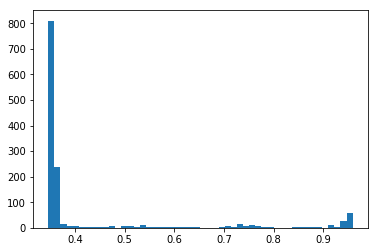

In [383]:
plt.hist(val_pred_prob, bins=50)
plt.show()